In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import spacy

In [ ]:
# Helper Functions #
####################
# Function to load and resize image


def preprocess_data(text,data_name):
    

    # Function to lemmatize text using spaCy
    def lemmatize_text(text):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc])
    if text:
        # Load spaCy model
        nlp = spacy.load("en_core_web_sm")
     # Load the data
    data = pd.read_csv(data_name)
    
    
    # Extract character names and remove from main data
    character_names = data.iloc[:, 0].tolist()
    main_data = data.iloc[:, 1:]

    # Identify numeric and text columns
    numeric_columns = main_data.select_dtypes(include=[np.number]).columns
    text_columns = main_data.select_dtypes(exclude=[np.number]).columns
    print(text_columns)
    # Preprocess numeric columns
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    numeric_data = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(main_data[numeric_columns])), 
                                columns=numeric_columns)
   

    # Preprocess text columns using TfidfVectorizer and spaCy lemmatization
    if text:
        tfidf = CountVectorizer()  # You can adjust max_features as needed
        text_data = main_data[text_columns].fillna('')
        text_data_combined = text_data.apply(lambda x: ' '.join(x), axis=1)
        print(text_data_combined)
        #lemmatized_text = text_data_combined.apply(lemmatize_text)
        tfidf_matrix = tfidf.fit_transform(text_data_combined)
        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
        processed_data = pd.concat([numeric_data,tfidf_df], axis=1)
    else:
        # Combine processed data 
        processed_data = pd.concat([numeric_data,], axis=1)
    


    return [processed_data,character_names]



def decompose_data(processed_data,character_names):
    def get_image(path, zoom=0.3):
        return OffsetImage(plt.imread(path), zoom=zoom)
    tsne = PCA(n_components=1)
    tsne_1d = tsne.fit_transform(processed_data)
    tsne_1d = pd.DataFrame(tsne_1d, columns=['x'])
    tsne_1d.insert(loc = 0,
          column = "Character",
          value = character_names)
    tsne_1d.to_csv("data-1d.csv",index=False)

    tsne2 = PCA(n_components=2)
    tsne_2d = tsne2.fit_transform(processed_data)
    tsne_2d = pd.DataFrame(tsne_2d, columns=['x', 'y'])
    tsne_2d.insert(loc = 0,
          column = "Character",
          value = character_names)
    tsne_2d.to_csv("data-2d.csv",index=False)
    
    # Create a graph with images
    plt.figure(figsize=(20, 16))
    scatter = plt.scatter(tsne_2d['x'], tsne_2d['y'], alpha=0)

    for i, character in enumerate(tsne_2d['Character']):
        try:
            img_path = os.path.join('pokemon_images', f"{character.lower().replace(' ', '_')}.png")
            ab = AnnotationBbox(get_image(img_path), (tsne_2d['x'][i], tsne_2d['y'][i]), frameon=False)
            plt.gca().add_artist(ab)
        except FileNotFoundError:
            print(f"Image not found for {character}")

    plt.suptitle('Pokemon Unite Character Analysis', fontsize=36)
    plt.xlabel('Overall Efficency')
    plt.ylabel('Jungle vs Lane Efficency')
    plt.tight_layout()
    plt.savefig('KPCA_clustering_images.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("Processing complete. Results saved to 'clustered_main_data.csv' and 'TSNE_clustering_images.png'.")


df,chars = preprocess_data(False,"RAW.csv")
decompose_data(df,chars)



Index(['WR', 'PR', 'BR'], dtype='object')
Processing complete. Results saved to 'clustered_main_data.csv' and 'TSNE_clustering_images.png'.


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
data = pd.read_csv("Pokemon Data.csv")
# Drop the first column and normalize the remaining data
labels = data.iloc[:,0]
data_values = data.drop(columns=['Pokemon'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_values)

# Perform PCA with 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Perform Kernel PCA with 2 components
kpca = KernelPCA(n_components=2, kernel='rbf')
kpca_data = kpca.fit_transform(scaled_data)

# Convert PCA and KPCA results to dataframes for easy handling
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
kpca_df = pd.DataFrame(kpca_data, columns=['KPCA1', 'KPCA2'])

# Display the first few rows of the PCA and KPCA results
(labels.head(),pca_df.head(), kpca_df.head())

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow method to determine the optimal number of clusters
def elbow_method(data):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    return sse

# Plot the elbow method for PCA data
reg_sse = elbow_method(scaled_data)
pca_sse = elbow_method(pca_df)
kpca_sse = elbow_method(kpca_df)

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(range(1, 11), reg_sse, marker='p', label='Raw')
plt.plot(range(1, 11), pca_sse, marker='o', label='PCA')
plt.plot(range(1, 11), kpca_sse, marker='s', label='KPCA')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\jaylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



      Elements       PC1       PC2  0
0        Absol  0.076419 -0.359922  3
1    Aegislash  1.382083  1.184405  4
2    Armarouge -0.211022  0.578002  1
3    Azumarill  0.391873  0.545655  1
4    Blastoise  0.723161 -2.470251  0
..         ...       ...       ... ..
65    Venusaur  0.607454 -0.157788  3
66  Wigglytuff  0.320013  0.780136  1
67      Zacian  0.248153  1.014617  1
68     Zeraora -0.031371 -0.008201  3
69     Zoroark  0.040489 -0.242682  3

[70 rows x 4 columns]


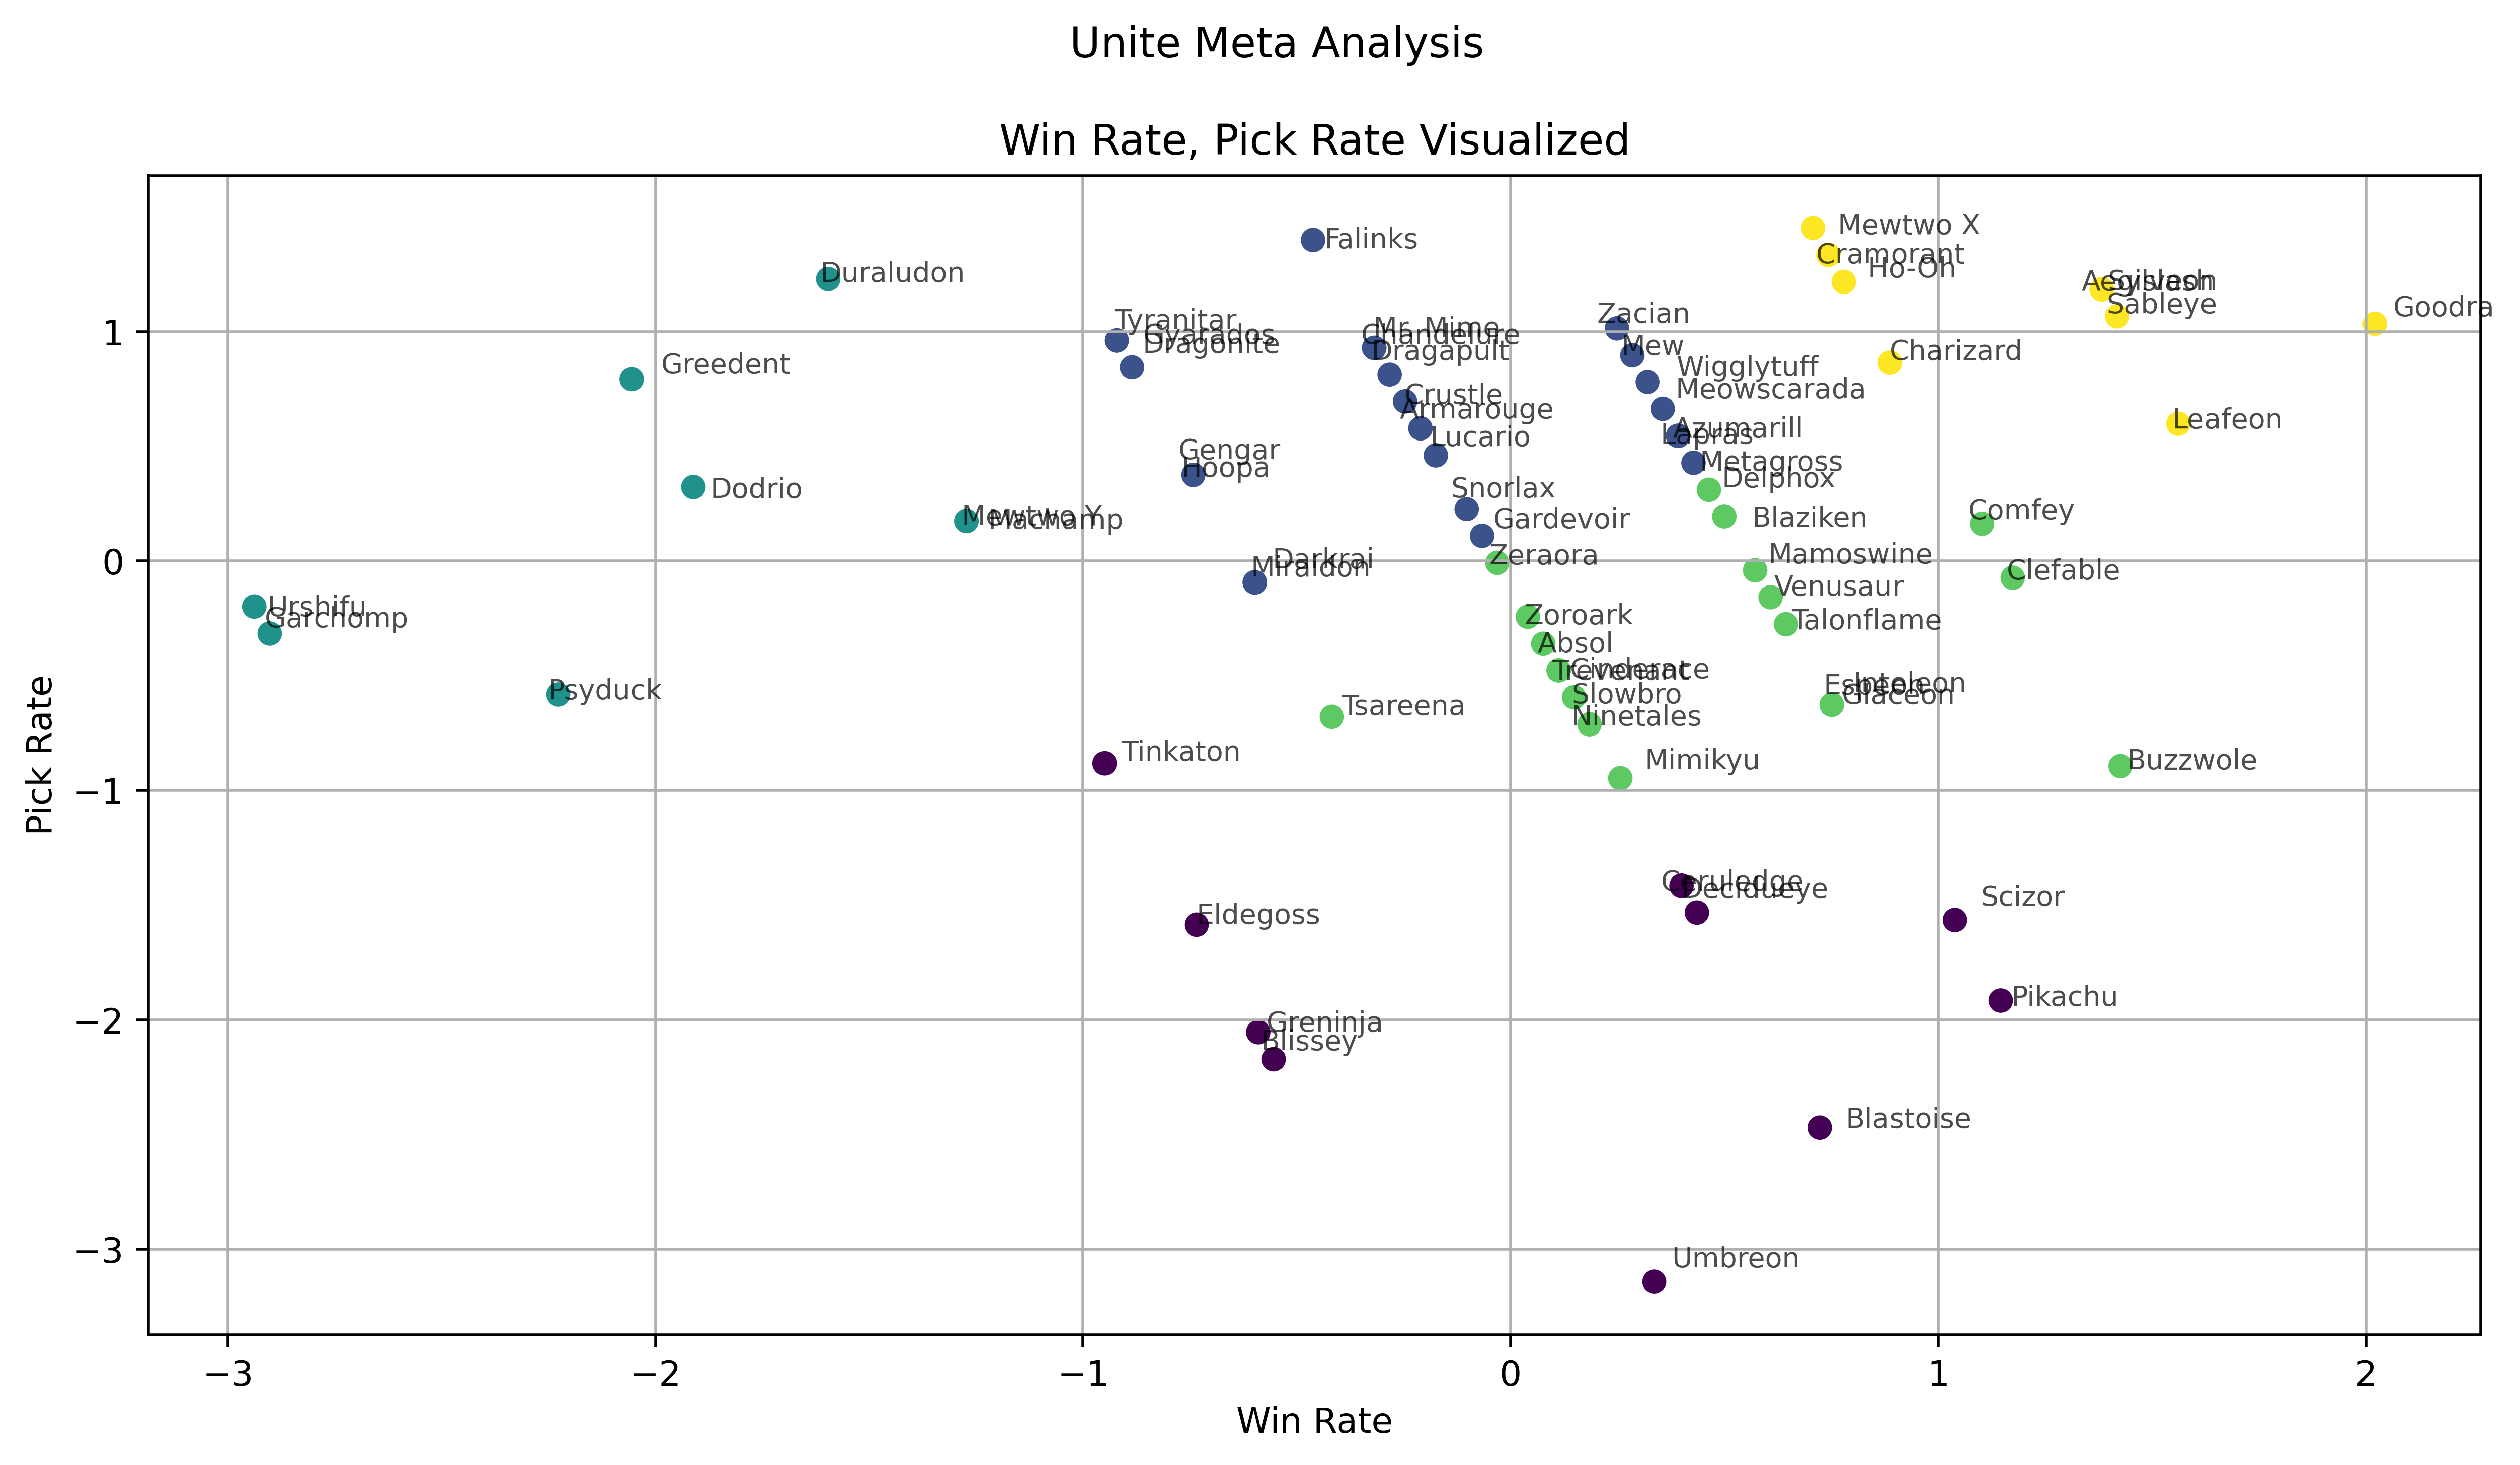

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import random
data = pd.read_csv("raw2.csv")
# Drop the first column and normalize the remaining data
labels = data.iloc[:,0]
data_values = data.drop(columns=['Elements'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_values)

# Perform PCA with 2 components
pca = FastICA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Perform Kernel PCA with 2 components
kpca = TSNE(n_components=2 )
kpca_data = kpca.fit_transform(scaled_data)

# Convert PCA and KPCA results to dataframes for easy handling
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
kpca_df = pd.DataFrame(kpca_data, columns=['PC1', 'PC2'])

clustering = KMeans(n_clusters=5).fit(pca_df)
print()
final = pd.concat([labels, pd.DataFrame(pca_df),pd.DataFrame(clustering.labels_) ], axis=1)
print(final)
# Plot the clustered KPCA data
plt.figure(figsize=(12, 6), dpi=500)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=clustering.labels_, cmap='viridis', marker='o')
for i, txt in enumerate(labels):
    plt.annotate(txt, (pca_df['PC1'][i]+(random.random()*.12)-0.05, pca_df['PC2'][i]+(random.random()*.12)-0.05), fontsize=8, alpha=0.7)
plt.xlabel('Win Rate')
plt.ylabel('Pick Rate')
plt.suptitle('Unite Meta Analysis')
plt.title('Win Rate, Pick Rate Visualized')
plt.grid(True)
plt.show()